**Avatars IDs**

- Mens US ASTM Sz M/40, MALE ID: "b4ec391f-4a63-41ad-8efd-f3e45c75bb28"

- Womens US ASTM Sz M/6, FEMALE ID: "ad80d4fd-cf03-4337-b42a-8df04ea07bcc"

# *Compute new positions of the garment*

Pieces 1
Pieces 15474
[227, 0, 1, 200, 201, 202, 74, 75, 76, 125, 126, 127, 183, 184, 185, 1556, 17, 18, 1296, 159, 160, 1293, 42, 43, 2179, 1783, 2, 1468, 1390, 203, 1612, 1876, 77, 1915, 80, 1697, 1785, 70, 1470, 1145, 89, 90, 1519, 2432, 61, 2022, 57, 1606, 2114, 102, 1288, 1739, 52, 1343, 1582, 41, 1293, 811, 138, 139, 1877, 128, 728, 1193, 141, 142, 1723, 151, 887, 1240, 2394, 156, 749, 161, 162, 2338, 1209, 176, 179, 2161, 1270, 1141, 5, 6, 1843, 862, 188, 2149, 26, 1019, 1424, 23, 1188, 1687, 193, 1485, 1045, 10, 11, 1945, 166, 1455, 2233, 110, 2164, 2241, 1427, 171, 2041, 213, 1778, 12, 2083, 1353, 1829, 115, 978, 1890, 1797, 1043, 1916, 123, 928, 2253, 1784, 133, 1498, 98, 1318, 1919, 223, 961, 1337, 55, 949, 1322, 1173, 137, 2021, 146, 948, 1325, 195, 196, 1172, 46, 47, 1495, 108, 1049, 2657, 1087, 1618, 1505, 1381, 93, 2029, 1396, 9, 2206, 1023, 1317, 1886, 1006, 479, 1164, 177, 178, 2555, 1230, 578, 31, 2229, 1674, 2114, 1290, 101, 1428, 154, 1169, 2530, 1133, 1634, 2304, 1

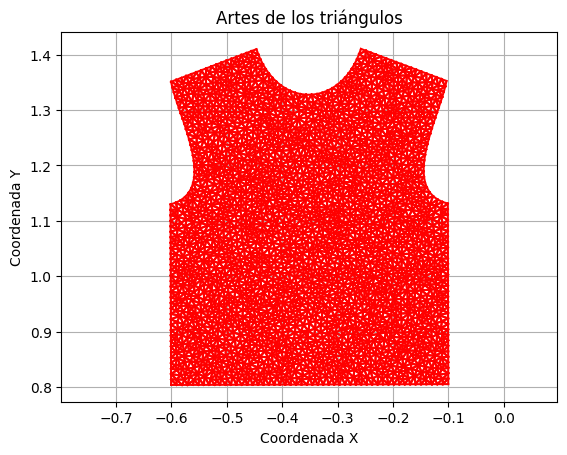

In [24]:
import json
import math
import numpy as np


#IMPORT SCENE
rute = 'prueba_horizontal_pom_bajo.json'

with open(rute) as archivo:
    data = json.load(archivo)

# Avatar & Pieces geometry data
avatar = data["avatar"]
pieces = data["pieces"]

#print("Avatar", avatar)

all_pieces_indices = []
all_pieces_position3d = []
all_pieces_position2d = []

pieza_front_indices = []
pieza_front_position2d = []

all_sewLines = []
all_pieces_position2d = []
longitud_acumulada = 0  
indice_mapeado = {}
# Rotation
def rotate_point(x, y, theta):
    x_rotated = x * math.cos(theta) - y * math.sin(theta)
    y_rotated = x * math.sin(theta) + y * math.cos(theta)
    return x_rotated, y_rotated
# ALL POMS TRANSFORMED POSITIONS
transformed_poms = []

for pom in data["poms"]:

    garment_piece_id = pom["garmentPieceId"]

    # TRANSFORM associated with pom
    for piece in data['pieces']:
        if piece['_id'] == garment_piece_id:
            rotation = piece['components']['transform2D']['rotation']
            translation = piece['components']['transform2D']['translation']
            break

    # POM COORDS
    pom_coords = [(point["position"]["x"], point["position"]["y"]) for point in pom["position"]["_path"]]
    transformed_pom_coords = []
    for x, y in pom_coords:
        # Rotation
        x_rotated, y_rotated = rotate_point(x, y, rotation)
        # Translation
        x_translated = x_rotated + translation['x']
        y_translated = y_rotated + translation['y']
        transformed_pom_coords.append((x_translated, y_translated))
    transformed_poms.append(transformed_pom_coords)

for piece in data['pieces']:
    if(garment_piece_id==piece['_id']):
        indices = piece['components']['garmentPiece']['geometry']['indices']
        position3D = piece['components']['garmentPiece']['geometry']['position3D']
        position2D = piece['components']['garmentPiece']['geometry']['position2D']    
        rotation = piece['components']['transform2D']['rotation']
        translation = piece['components']['transform2D']['translation']
        sewLine = piece['components']['garmentPiece']['sewLine']['path']    


        # Ajusta los índices y añádelos a la lista de índices acumulada
        # Ajusta los índices y añádelos a la lista de índices acumulada

        all_pieces_indices.extend(indices)
        #all_pieces_indices.extend(indices)


        all_pieces_position3d.extend(position3D)

        #GET PIECE 2D COORDINATES ROTATED & TRANSLATED
        for i in range(0, len(position2D), 2):

            x = position2D[i]
            y = position2D[i + 1]
            
            # Rotation
            x_rotated, y_rotated = rotate_point(x, y, rotation)

            # Translation
            x_translated = x_rotated + translation['x']
            y_translated = y_rotated + translation['y']
            
            # Update 2d coordinates
            position2D[i] = x_translated
            position2D[i + 1] = y_translated
        all_pieces_position2d.append({'garmentPiece_id': piece['_id'], 'position2D': position2D})

        if not pieza_front_position2d:  # Si es la primera vez, no hay que ajustar
            pieza_front_position2d.extend(position2D)
            pieza_front_indices.extend(indices)
        else:
            pieza_front_position2d.extend(position2D)
                
            # Ajustamos los índices y los extendemos
            ajuste_indices = len(position2D) 
            pieza_front_indices.extend([idx + ajuste_indices for idx in indices])

        for point in sewLine:
            x = point['position']['x']
            y = point['position']['y']
            
            # Rotar el punto
            x_rotated, y_rotated = rotate_point(x, y, rotation)
            
            # Aplicar translación
            x_translated = x_rotated + translation['x']
            y_translated = y_rotated + translation['y']
            
            # Actualizar las coordenadas del punto
            point['position']['x'] = x_translated
            point['position']['y'] = y_translated
            if 'control1' in point:
                # Rotar el punto de control1
                x_c1 = point['control1']['x']
                y_c1 = point['control1']['y']
                x_rotated_c1, y_rotated_c1 = rotate_point(x_c1, y_c1, rotation)
                
                # Aplicar translación al punto de control1 rotado
                x_translated_c1 = x_rotated_c1 + translation['x']
                y_translated_c1 = y_rotated_c1 + translation['y']
                
                # Actualizar las coordenadas del punto de control1
                point['control1']['x'] = x_translated_c1
                point['control1']['y'] = y_translated_c1

            if 'control2' in point:
                # Rotar el punto de control2
                x_c2 = point['control2']['x']
                y_c2 = point['control2']['y']
                x_rotated_c2, y_rotated_c2 = rotate_point(x_c2, y_c2, rotation)
                
                # Aplicar translación al punto de control2 rotado
                x_translated_c2 = x_rotated_c2 + translation['x']
                y_translated_c2 = y_rotated_c2 + translation['y']
                
                # Actualizar las coordenadas del punto de control2
                point['control2']['x'] = x_translated_c2
                point['control2']['y'] = y_translated_c2
        all_sewLines.append({'garmentPiece_id': piece['_id'], 'sewLine': sewLine})




        

print("Pieces", len(all_pieces_position2d))
print("Pieces", len(all_pieces_indices))
print(pieza_front_indices)
print(pieza_front_position2d)

import matplotlib.pyplot as plt

# Función para dibujar aristas de una pieza
def dibujar_aristas(indx, array):
    for i in range(0, len(indx), 3):
        # Tomar los índices de los vértices del triángulo actual
        v0_idx, v1_idx, v2_idx = indx[i:i+3]
        v0 = array[v0_idx*2:v0_idx*2+2]  # Extraemos las coordenadas x e y del vértice
        v1 = array[v1_idx*2:v1_idx*2+2]
        v2 = array[v2_idx*2:v2_idx*2+2]
        plt.plot([v0[0], v1[0]], [v0[1], v1[1]], 'r-')
        plt.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')
        plt.plot([v2[0], v0[0]], [v2[1], v0[1]], 'r-')

# Dibujar las aristas de todas las piezas
dibujar_aristas(pieza_front_indices,pieza_front_position2d)

# Configuraciones adicionales del gráfico
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Artes de los triángulos')
plt.grid(True)
plt.axis('equal')  # Hacer que los ejes sean iguales

# Mostrar el gráfico
plt.show()

In [25]:
import numpy as np

#Convert to numpy arrays & matrix
avatar_indices = np.array(avatar["indices"])
avatar_positions = np.array(avatar["positions"]).reshape(-1, 3)  # 3 colum matrix 

pieces_indices_withoutfilter = np.array(all_pieces_indices)
pieces_positions = np.array(all_pieces_position3d).reshape(-1, 3)  # 3 colum matrix 
pieces_positions2d = np.array(all_pieces_position2d)
bezier_2d = np.array(all_sewLines)
pieces_bezierPath = np.array(all_sewLines)

print(len(pieces_indices_withoutfilter))


15474


In [26]:
# Compute min distances garment-avatar
min_distances = np.zeros(len(pieces_positions))
ac = np.zeros(len(pieces_positions), dtype=int) # Avatar Correspondences

# For all vertex in the garment
for i, pos_prenda in enumerate(pieces_positions):
    dist_vertex = np.linalg.norm(pos_prenda - avatar_positions, axis=1)
    # Find nearest avatar index and compute min distance
    nearest_indice_vertex = np.argmin(dist_vertex)
    min_dist = dist_vertex[nearest_indice_vertex]
    #print(distancias_vertice[indice_vertice_cercano])

    # Save min distances and avatar index correspondences
    min_distances[i] = min_dist
    ac[i] = nearest_indice_vertex



In [27]:
# Offset between garment vertex and its nearest avatar vertex
offsets = np.zeros_like(pieces_positions)

for i, indice_avatar in enumerate(ac):
    offset = np.array(pieces_positions[i])- np.array(avatar_positions[indice_avatar])  
    offsets[i]=offset

#print(offsets)



New Avatar

In [28]:
#IMPORT NEW AVATAR
avatars = 'avatars.json'

with open(avatars) as file:
    avatars_data = json.load(file)
new_avatar = avatars_data["big-female"]

new_avatar_positions= np.array(new_avatar["positions"]).reshape(-1, 3)  # 3d colum matrix


In [29]:
#Compute new pieces positions with the offset computed and its nearest avatar index from the new avatar (Avatars in seddi have the same mesh)
new_pieces_positions = np.zeros_like(pieces_positions)

for i, indice_avatar in enumerate(ac):
    new_pieces_positions[i] = np.array(new_avatar_positions[indice_avatar]) + np.array(offsets[i])

print(len(new_pieces_positions))


2694


In [30]:
#Export SCENE TO JSON for AUTHOR

import json
#IMPORT SCENE
rute = 'prueba_horizontal_pom_bajo.json'

with open(rute) as archivo:
    data = json.load(archivo)


pieces = data["pieces"]
new_list_positions = new_pieces_positions.reshape(-1).tolist()

for piece in data['pieces']:
    indices = piece['components']['garmentPiece']['geometry']['indices']
    positions = piece['components']['garmentPiece']['geometry']['position3D']

    # Len atucal piece
    length_piece = len(positions)
    # Get new positions actual piece
    new_positions = new_list_positions[:length_piece]

    # Remplace for new positions
    piece['components']['garmentPiece']['geometry']['position3D'] = new_positions
    
    # Update new_pieces_positions to next piece
    new_list_positions = new_list_positions[length_piece:]

with open("output.json", "w") as outfile: 
      json.dump(data, outfile)
print("Datos exportados a 'output.json'")



Datos exportados a 'output.json'


DEFORMATION METRICS FOR 2D PATTERN

POM: C0: -0.6007007494704346 0.8511291109790472 C1: -0.10057036570909689 0.8511360229024144


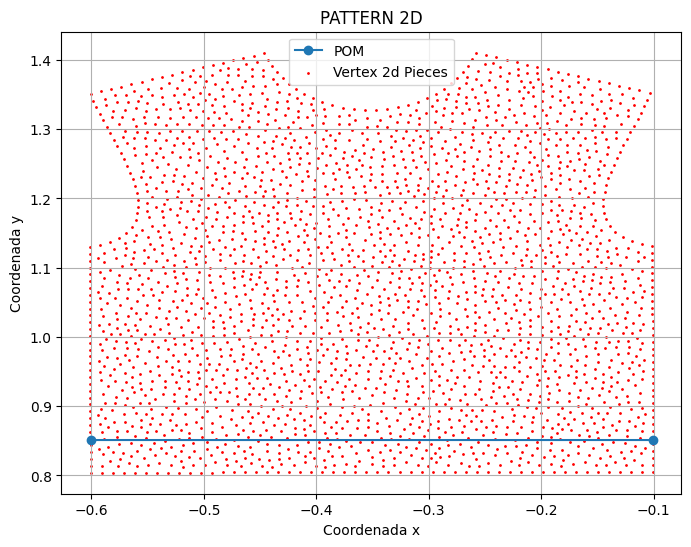

2694


In [31]:
#Vertex defined by POM POINTS
import matplotlib.pyplot as plt


#GET POMS COORDINATES
class Coordinates:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

poms = data["poms"]
#print(transformed_poms[0][0][0])
pom_C0=Coordinates(transformed_poms[0][0][0],transformed_poms[0][0][1])
pom_C1=Coordinates(transformed_poms[0][1][0],transformed_poms[0][1][1])


POM = transformed_poms
print("POM:","C0:",pom_C0.x,pom_C0.y,"C1:",pom_C1.x,pom_C1.y)

#print(pieces_positions2d)
pieces_2d = []
for piece_data in pieces_positions2d:
    position2d = piece_data['position2D']
    for i in range(0, len(position2d), 2):
        x = position2d[i]
        y = position2d[i + 1]
        pieces_2d.append(Coordinates(x, y))


# PLOT
plt.figure(figsize=(8, 6))

plt.plot([pom_C0.x, pom_C1.x], [pom_C0.y, pom_C1.y], marker='o', label='POM')


plt.scatter([position.x for position in pieces_2d], 
            [position.y for position in pieces_2d], 
            color='red',s=1, label='Vertex 2d Pieces')


plt.xlabel('Coordenada x')
plt.ylabel('Coordenada y')
plt.title('PATTERN 2D')
plt.legend()

plt.grid(True)
plt.show()

print(len(pieces_2d))


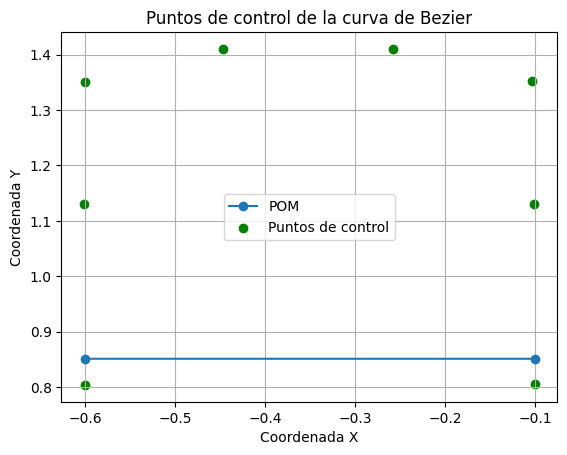

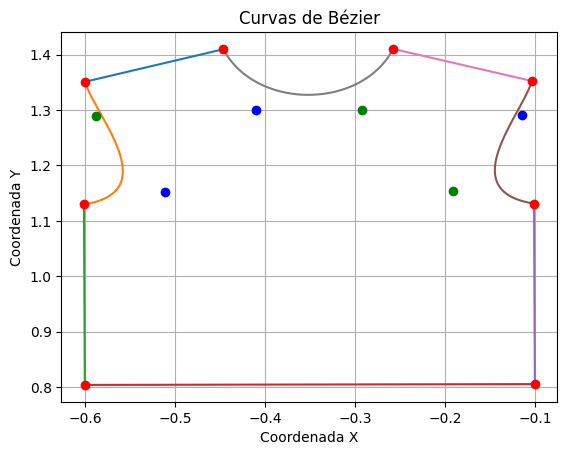

In [32]:
#1. HOW POM AFFECT BEZIER CONTROL POINTS: SEWLINE

# x : Slider value
#f(x) : return  NEW POSITIONS POINTS WITH DISPLACEMENT

# DIBUJAR
positions_array = np.array([(point['position']['x'], point['position']['y']) for piece in bezier_2d for point in piece['sewLine']])
plt.plot([pom_C0.x, pom_C1.x], [pom_C0.y, pom_C1.y], marker='o', label='POM')

# Graficar los puntos
plt.scatter(positions_array[:, 0], positions_array[:, 1], color='green', label='Puntos de control')

# Mostrar la gráfica
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Puntos de control de la curva de Bezier')
plt.legend()
plt.grid(True)
plt.show()


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

def plot_bezier_curves(bezier_2d):
    # Función para calcular el punto en la curva de Bézier
    def bezier(t, P0, P1=None, P2=None, P3=None):
        if P1 is None or P2 is None:
            # Si solo hay dos puntos, calcula la interpolación lineal
            return [(1-t)*P0[i] + t*P3[i] for i in range(2)]
        else:
            # Si hay cuatro puntos, calcula la curva de Bézier
            return [(1-t)**3 * P0[i] + 3 * (1-t)**2 * t * P1[i] + 3 * (1-t) * t**2 * P2[i] + t**3 * P3[i] for i in range(2)]

    # Crear figura y ejes una vez
    plt.figure()
    ax = plt.gca()
    all_curves_points = []

    # Iterar sobre cada elemento en bezier_2d
    for bezier_data in bezier_2d:
        sewLine = bezier_data['sewLine']
        
        # Generar valores de t (parámetro)
        t_values = np.linspace(0, 1, 2000)

        # Iterar sobre cada par de puntos en sewLine
        for i in range(len(sewLine) - 1):
            P0 = [sewLine[i]['position']['x'], sewLine[i]['position']['y']]
            P3 = [sewLine[i+1]['position']['x'], sewLine[i+1]['position']['y']]
            
            if 'control1' in sewLine[i] and 'control2' in sewLine[i]:
                P1 = [sewLine[i]['control1']['x'], sewLine[i]['control1']['y']]
                P2 = [sewLine[i]['control2']['x'], sewLine[i]['control2']['y']]
            else:
                P1 = None
                P2 = None
            
            curve_points = np.array([bezier(t, P0, P1, P2, P3) for t in t_values])
            all_curves_points.append(curve_points)

            ax.plot(curve_points[:,0], curve_points[:,1], label=f'Curva {i+1} de Bézier')

        # Unir el último punto con el primero
        P0_last = [sewLine[0]['position']['x'], sewLine[0]['position']['y']]
        P3_first = [sewLine[-1]['position']['x'], sewLine[-1]['position']['y']]

        if 'control1' in sewLine[-1] and 'control2' in sewLine[-1]:
            P2_first = [sewLine[-1]['control1']['x'], sewLine[-1]['control1']['y']]
            P1_first = [sewLine[-1]['control2']['x'], sewLine[-1]['control2']['y']]
        else:
            P1_first = None
            P2_first = None

        # Verificamos si hay puntos de control y los incluimos en el cálculo
        if P1_first is not None and P2_first is not None:
            curve_points = np.array([bezier(t, P0_last, P1_first, P2_first, P3_first) for t in t_values])
        else:
            curve_points = np.array([bezier(t, P0_last, None, None, P3_first) for t in t_values])
        all_curves_points.append(curve_points)

        ax.plot(curve_points[:,0], curve_points[:,1], label=f'Curva cerrada de Bézier')
        # Añadir puntos de control y primeros y últimos puntos
        for i, point in enumerate(sewLine):
            ax.plot(point['position']['x'], point['position']['y'], 'ro', label=f'Punto {i}')
            if 'control1' in point:
                ax.plot(point['control1']['x'], point['control1']['y'], 'go', label=f'Control 1 {i}')
            if 'control2' in point:
                ax.plot(point['control2']['x'], point['control2']['y'], 'bo', label=f'Control 2 {i}')

    # Personalizar la leyenda
    #ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Configurar ejes y etiquetas
    ax.set_xlabel('Coordenada X')
    ax.set_ylabel('Coordenada Y')
    ax.set_title('Curvas de Bézier')
    ax.grid(True)

    # Mostrar la gráfica
    plt.show()
    return all_curves_points

# Llamar a la función para graficar las curvas de Bézier
all_curve_points = plot_bezier_curves(bezier_2d)





#print(len(points_inside_array))


2694
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

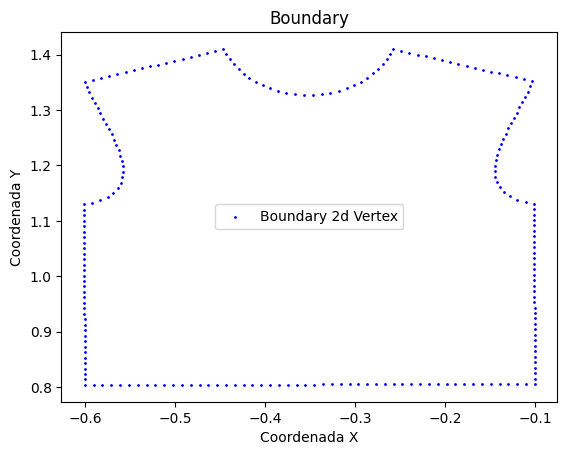

In [33]:
boundary_curves= np.concatenate(all_curve_points, axis=0)

points_inside = []

# Umbral de distancia
threshold = 0.001  # Puedes ajustar este valor según tus necesidades

print(len(pieces_2d))
boundary_index=[]
num=0
# Iterar sobre los objetos Coordinates en pieces_2d
for i, coord in enumerate(pieces_2d):
    # Coordenadas x e y del objeto Coordinates
    x = coord.x
    y = coord.y
    
    # Calcular la distancia euclidiana entre el punto (x, y) y cada punto en boundary_curves
    distances = np.linalg.norm(boundary_curves - np.array([x, y]), axis=1)
    
    # Verificar si alguna de las distancias es menor que el umbral
    if any(distances < threshold):
        points_inside.append((x, y))
        boundary_index.append(num)
    num=num+1

print(boundary_index)
pieces_indices = [index for index in pieces_indices_withoutfilter if index not in boundary_index]

print("Índices restantes:",len(pieces_indices), len(pieces_indices_withoutfilter))

print(len(boundary_index))
# Convertir points_inside a un array NumPy para facilitar la manipulación
points_inside_array = np.array(points_inside)
# Extraer las coordenadas x e y de los puntos dentro de points_inside_array
x_inside = points_inside_array[:, 0]
y_inside = points_inside_array[:, 1]

# Dibujar los puntos
plt.scatter(x_inside, y_inside, color='blue', label='Boundary 2d Vertex',s=1)
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Boundary')
plt.legend()
plt.show()


2694
2694
2693
Diferencia en longitudes de aristas entre los dos avatares:


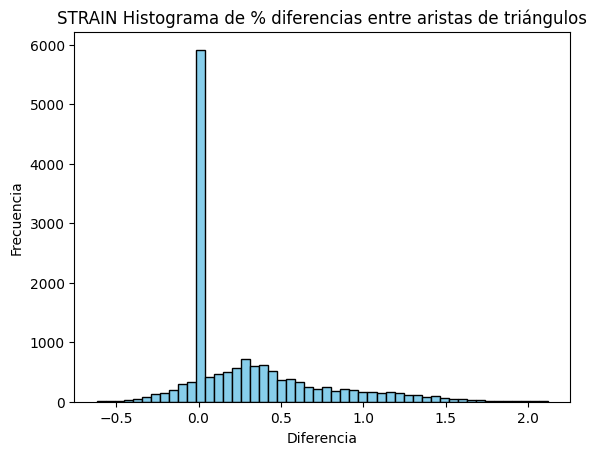

In [34]:
#COMPUTE DEFORMATION METRIC 3D: EDGE LENGTH

def compute_edge_lengths(points, indices):
    edge_lengths = []
    for i in range(0, len(indices), 3):
        # Obtener los índices de los puntos que forman el triángulo
        p1_index, p2_index, p3_index = indices[i], indices[i+1], indices[i+2]
        # Obtener las posiciones 3D de los puntos del triángulo
        p1 = points[p1_index]
        p2 = points[p2_index]
        p3 = points[p3_index]

            # Calcular la longitud de cada arista usando np.linalg.norm
        edge_ab = np.linalg.norm(p2 - p1)
        edge_bc = np.linalg.norm(p3 - p2)
        edge_ca = np.linalg.norm(p1 - p3)

        edge_lengths.append(edge_ab)
        edge_lengths.append(edge_bc)
        edge_lengths.append(edge_ca)

    return edge_lengths

def compute_edge_difference(avatar1_lengths, avatar2_lengths):
    if len(avatar1_lengths) != len(avatar2_lengths):
        raise ValueError("AVATARS NEED SAME NUMBER OF EDGES.")
    
    differences = np.abs(np.array(avatar1_lengths) - np.array(avatar2_lengths))
    return differences
    
def compute_edge_strain(current_length, original_length):
    if original_length == 0:
        return 0
    return current_length / original_length - 1

def compute_total_strain(current_lengths, original_lengths):
    total_strain = []
    for current_length, original_length in zip(current_lengths, original_lengths):
        strain = compute_edge_strain(current_length, original_length)
        total_strain.append(strain)
    
    return np.array(total_strain)


avatar1_3dpoints = pieces_positions
avatar2_3dpoints = new_pieces_positions
print(len(pieces_positions))
print(len(new_pieces_positions))
print(np.max(pieces_indices))


# COMPUTE EDGE LENGTHS Avatar 1 & Avatar 2
avatar1_edge_lengths = compute_edge_lengths(avatar1_3dpoints,pieces_indices_withoutfilter)
avatar2_edge_lengths = compute_edge_lengths(avatar2_3dpoints,pieces_indices_withoutfilter)

# Compute the difference in edge lengths between the two avatars
diff_edges = compute_edge_difference(avatar1_edge_lengths, avatar2_edge_lengths)

target_strain = compute_total_strain(np.array(avatar2_edge_lengths),np.array(avatar1_edge_lengths)).flatten()

print("Diferencia en longitudes de aristas entre los dos avatares:")

# Crear el histograma
plt.hist(target_strain, bins=50, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('STRAIN Histograma de % diferencias entre aristas de triángulos')

# Mostrar el histograma
plt.show()


In [35]:
import numpy as np

# Función para calcular los puntos de la curva de Bezier
def bezier(t, P0, P1, P2, P3):
    return (1 - t)**3 * P0 + 3 * (1 - t)**2 * t * P1 + 3 * (1 - t) * t**2 * P2 + t**3 * P3

# Función para encontrar el segmento y el parámetro t de un punto en las curvas de Bézier
def find_segment_and_t(all_curve_points, point):
    """
    Encuentra el segmento y el parámetro t de un punto en las curvas de Bézier.

    Args:
    all_curve_points (list): Lista de puntos de las curvas de Bézier.
    point (list): Coordenadas [x, y] del punto a buscar.

    Returns:
    tuple: El índice del segmento y el valor de t correspondiente.
    """
    # Inicializar las variables para el punto más cercano y su distancia mínima
    closest_point = None
    min_distance = float('inf')
    segment_index = -1
    
    # Iterar sobre cada conjunto de puntos de las curvas de Bézier
    for index, curve_points in enumerate(all_curve_points):
        # Calcular la distancia euclidiana entre el punto dado y cada punto en la curva de Bézier
        distances = np.linalg.norm(curve_points - point, axis=1)
        
        # Encontrar el punto más cercano en la curva de Bézier
        closest_index = np.argmin(distances)
        closest_distance = distances[closest_index]
        
        # Si la distancia al punto más cercano es menor que la mínima registrada hasta ahora, actualizar
        if closest_distance < min_distance:
            closest_point = curve_points[closest_index]
            min_distance = closest_distance
            segment_index = index
    
    # Calcular el valor de t correspondiente al punto más cercano
    if closest_point is not None:
        t_value = np.where(np.all(all_curve_points[segment_index] == closest_point, axis=1))[0][0] / (len(all_curve_points[segment_index]) - 1)
        return segment_index, t_value
    else:
        return None, None


In [36]:
print(points_inside_array)
print(bezier_2d)

# Definir puntos del borde de la malla en funcion de la sewLine

# Función para recalcular un punto en la curva de Bezier dado un segmento y un valor de t
def recalculate_point(all_curve_points, segment_index, t_value):

    # Obtener los puntos del segmento dado
    curve_points = all_curve_points[segment_index]
    
    # Calcular el índice correspondiente al valor de t
    index = int(t_value * (len(curve_points) - 1))
    
    # Devolver las coordenadas del punto en ese índice
    return curve_points[index]




[[-0.44658538  1.40976734]
 [-0.45564236  1.40630953]
 [-0.46469934  1.40285179]
 [-0.47375632  1.39939398]
 [-0.48281331  1.3959362 ]
 [-0.49187027  1.39247839]
 [-0.50092728  1.38902061]
 [-0.50998425  1.3855628 ]
 [-0.51904124  1.38210505]
 [-0.52809822  1.37864722]
 [-0.53715522  1.37518944]
 [-0.5462122   1.37173163]
 [-0.5552692   1.36827385]
 [-0.56432621  1.36481607]
 [-0.57338318  1.36135826]
 [-0.58244017  1.35790049]
 [-0.59149716  1.35444271]
 [-0.60055416  1.3509849 ]
 [-0.5983354   1.34131229]
 [-0.59565298  1.33175686]
 [-0.59269905  1.32228144]
 [-0.58958548  1.31285715]
 [-0.58638629  1.30346149]
 [-0.58315606  1.29407643]
 [-0.57993916  1.28468683]
 [-0.57677556  1.27527915]
 [-0.57369997  1.26584237]
 [-0.57075392  1.25636438]
 [-0.56797436  1.24683632]
 [-0.56541134  1.23724788]
 [-0.56311766  1.2275916 ]
 [-0.56116594  1.2178607 ]
 [-0.55963768  1.20805479]
 [-0.55864951  1.19818025]
 [-0.55835638  1.18826162]
 [-0.55896034  1.17835906]
 [-0.56070975  1.16859689]
 

In [37]:
import numpy as np
bezier_curve = np.concatenate(all_curve_points, axis=0)

def find_intersection_points(bezier_curve, ray, orientation):
    intersection_points = []
    if(orientation=='horizontal'):

        for i in range(len(bezier_curve) - 1):
            # Check for intersection between line segment and ray
            y1, y2 = bezier_curve[i][1], bezier_curve[i+1][1]
            if (y1 >= ray and y2 <= ray) or (y1 <= ray and y2 >= ray):
                # Interpolate x value at intersection point
                t = (ray - y1) / (y2 - y1)
                intersection_x = bezier_curve[i][0] + t * (bezier_curve[i+1][0] - bezier_curve[i][0])
                intersection_points.append((intersection_x, ray))
        return intersection_points
    else:     
        for i in range(len(bezier_curve) - 1):
        # Obtener coordenadas x de los puntos del segmento
            x1, x2 = bezier_curve[i][0], bezier_curve[i+1][0]
            
            # Verificar si el segmento intersecta con la línea vertical
            if (x1 >= ray and x2 <= ray) or (x1 <= ray and x2 >= ray):
                # Interpolar el valor y en el punto de intersección
                t = (ray - x1) / (x2 - x1)
                intersection_y = bezier_curve[i][1] + t * (bezier_curve[i+1][1] - bezier_curve[i][1])
                intersection_points.append((ray, intersection_y))
        return intersection_points

def closest_points_to_P(intersection_points, P, orientation):
    if(orientation=='horizontal'):
        left_point, right_point = None, None
        min_dist_left, min_dist_right = float('inf'), float('inf')
        for point in intersection_points:
            dist = np.linalg.norm(np.array(P) - np.array(point))
            if point[0] < P[0] and dist < min_dist_left:
                left_point = point
                min_dist_left = dist
            elif point[0] > P[0] and dist < min_dist_right:
                right_point = point
                min_dist_right = dist

        return left_point, right_point
    else:
        above_point, below_point = None, None
        min_dist_above, min_dist_below = float('inf'), float('inf')
        for point in intersection_points:
            dist = np.linalg.norm(np.array(P) - np.array(point))
            # Verificar si el punto está arriba o abajo de P en el eje y
            if point[1] > P[1] and dist < min_dist_above:
                above_point = point
                min_dist_above = dist
            elif point[1] < P[1] and dist < min_dist_below:
                below_point = point
                min_dist_below = dist
        return above_point, below_point


def nearest_indices(array_nearest, array_points):
    indices = []
    for point in array_nearest:
        # Calcular las distancias entre el punto actual y todos los puntos en array_points
        distances = np.linalg.norm(array_points - point, axis=1)
        # Encontrar el índice del punto más cercano
        nearest_index = np.argmin(distances)
        indices.append(nearest_index)
    return indices


def boundary_points(intersection_points, point_left):
    # Calcular las distancias euclidianas entre los puntos de intersección y point_left
    distances = np.linalg.norm(intersection_points - np.array([point_left[0], point_left[1]]), axis=1)
    
    # Obtener los índices de los puntos más cercanos (ordenados de menor a mayor distancia)
    nearest_indices = np.argsort(distances)
    
    # Tomar los dos puntos más cercanos
    nearest_boundary_points = [intersection_points[i] for i in nearest_indices[:2]]
    
    return nearest_boundary_points


def calculate_angle(point1, point2):
    """
    Calcula el ángulo entre dos puntos y el eje x.
    """
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    return np.arctan2(dy, dx)

def reorder_indices(reference_points, P):
    """
    Reordena los índices de los puntos de referencia en función del ángulo con el punto P.
    """
    angles = [calculate_angle(P, point) for point in reference_points]
    indices = np.argsort(angles)
    return indices




def is_convex_quadrilateral(points):
    """
    Verifica si los puntos forman un cuadrilátero convexo.
    """
    def cross_product(p1, p2, p3):
        """
        Calcula el producto cruzado de dos vectores formados por los puntos p1, p2, y p3.
        """
        return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

    n = len(points)
    for i in range(n):
        # Calcula el producto cruzado para cada tripleta de puntos adyacentes
        j = (i + 1) % n
        k = (i + 2) % n
        cross = cross_product(points[i], points[j], points[k])
        # Si el producto cruzado es negativo, indica que los puntos no están en orden convexo
        if cross < 0:
            return False
    return True


def calculate_weights(points, P):
    x_p, y_p = P
    weights = []
    for x, y in points:
        distance = np.sqrt((x - x_p)**2 + (y - y_p)**2)
        weights.append(1 / distance)  # Inverse distance weighting
    total_weight = sum(weights)
    return [w / total_weight for w in weights]  # Normalize weights
    """
    A = points[0]
    B = points[1]
    C = points[2]
    v0 = C - A
    v1 = B - A
    v2 = P - A

    # Calculate dot products
    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)

    # Compute barycentric coordinates
    inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
    u = (dot11 * dot02 - dot01 * dot12) * inv_denom
    v = (dot00 * dot12 - dot01 * dot02) * inv_denom
    w = 1 - u - v
    return u, v, w
        """

def bilinear_interpolation(points, weights):
    interpolated_x = sum(w * x for w, (x, _) in zip(weights, points))
    interpolated_y = sum(w * y for w, (_, y) in zip(weights, points))
    """
    u=weights[0]
    v=weights[1]
    w=weights[2]

    weighted_sum = u * points[0] + v * points[1] + w * points[2]

    
    return weighted_sum[0], weighted_sum[1]
    """
    return interpolated_x,interpolated_y


def vertex_weights_nearest_points(P, orientation, bezier_curve, points_inside_array):
    #plt.figure(figsize=(8, 6))

    if orientation == 'horizontal':
        ray = P[1]
        #plt.axhline(y=ray, color='gray', linestyle='--', label='Ray')

    else:
        ray = P[0]
        #plt.axvline(x=ray, color='gray', linestyle='--', label='Ray')

    #plt.scatter(*zip(*points_inside_array), color='blue',s=1, label='Points Inside')
    #plt.scatter(*zip(P), color='green', label='P')

    intersection_points = find_intersection_points(bezier_curve, ray, orientation)

    #plt.scatter(*zip(*intersection_points), color='red',s=5, label='Intersection Points')
    #plt.plot(*zip(*bezier_curve), color='black', label='Bezier Curve')

    left_point, right_point = closest_points_to_P(intersection_points, P, orientation)

    #plt.scatter(*zip(left_point), color='orange', label='Left Point')
    #plt.scatter(*zip(right_point), color='purple', label='Right Point')

    nearest_boundary_points_left = boundary_points(points_inside_array, left_point)
    nearest_boundary_points_right = boundary_points(points_inside_array, right_point)
    nearest_boundary_points = nearest_boundary_points_left + nearest_boundary_points_right
    #plt.scatter(*zip(*nearest_boundary_points_left), color='cyan', label='Nearest Boundary Points (Left)')
    #plt.scatter(*zip(*nearest_boundary_points_right), color='magenta', label='Nearest Boundary Points (Right)')

    nearest_indices_of_points = nearest_indices(nearest_boundary_points, points_inside_array)

    reordered_indices = reorder_indices(points_inside_array[nearest_indices_of_points], P)

    reordered_nearest_indices_of_points = [nearest_indices_of_points[i] for i in reordered_indices]


    weights = calculate_weights(points_inside_array[reordered_nearest_indices_of_points], P)
    #plt.xlabel('X')
    #plt.ylabel('Y')
    #plt.title('Intersection Points and Nearest Boundary Points')
    #plt.legend()
    #plt.grid(True)
    #plt.show()
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(*zip(*intersection_points), color='red',s=5, label='Intersection Points')
    plt.scatter(*zip(P), color='green', label='P')
    plt.scatter(*zip(*nearest_boundary_points_left), color='cyan', label='Nearest Boundary Points (Left)')
    plt.scatter(*zip(*nearest_boundary_points_right), color='magenta', label='Nearest Boundary Points (Right)')
    plt.scatter(*zip(left_point), color='orange', label='Left Point')
    plt.scatter(*zip(right_point), color='purple', label='Right Point')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Intersection Points and Nearest Boundary Points')
    plt.legend()
    plt.grid(True)
    plt.show()
    """
    return weights, reordered_nearest_indices_of_points

# Example usage:
#points_array = [(-0.35, 1.35),(-0.20043471708731297, 1.20109981477757)]   # Point on ray


points_array = []

for piece_data in pieces_positions2d:
    position2d = piece_data['position2D']
    for i in range(0, len(position2d), 2):
        x = position2d[i]
        y = position2d[i + 1]
        point = [x, y]
        if not np.any(np.all(points_inside_array == point, axis=1)):
            points_array.append(point)
print(len(points_array))

2466


In [38]:
import math
import copy

orientation='horizontal'

def get_sewline_by_id(id,bezier):
    for piece in bezier:
        if piece['garmentPiece_id'] == id:
            sewLine = piece['sewLine']
            return sewLine
    return None

def update_sewline_in_pieces(sewline, id,bezier):
    # Hacer una copia de bezier_2d
    for piece in bezier:
        if piece['garmentPiece_id'] == id:
            piece['sewLine'] = sewline



def calcular_desplazamiento(p1,p2, orientacion, diferencia_longitud):
    ajuste_mitad =  diferencia_longitud / 2

    if orientacion == 1:
        ajuste_mitad = diferencia_longitud

    desplazamiento_x = ajuste_mitad
    desplazamiento_y = ajuste_mitad

    if orientacion == 0:

        desplazamiento_y = 0
    elif orientacion == 1:
        desplazamiento_x = 0
        
    elif orientacion == 2:
      dx = p2.x - p1.x
      dy = p2.y - p1.y
      dist = math.sqrt(dx * dx + dy * dy)

      ux = math.abs(dx / dist)
      uy = dy / dist


      direccionOriginal = { x: ux, y: uy }

      desplazamiento_x = direccionOriginal.x * ajuste_mitad
      desplazamiento_y= direccionOriginal.y * ajuste_mitad

    return desplazamiento_x, desplazamiento_y



def desplazar_puntos_sewline_en_pom(sewline, indices_desplazar, despX, despY):
    for idx in indices_desplazar:
        if 0 <= idx < len(sewline):
            point = sewline[idx]
            #print(point)
            
            # Desplazar el punto principal
            point['position']['x'] -= despX
            point['position']['y'] -= despY

            # Si el punto tiene puntos de control, también desplazarlos
            #if 'control1' in point:
            #    point['control1']['x'] -= despX
            #    point['control1']['y'] -= despY
            #if 'control2' in point:
            #    point['control2']['x'] -= despX
            #    point['control2']['y'] -= despY




# Lista para almacenar los segmentos y los parámetros t para todos los puntos del borde
boundary_vertex_segment_t = []

# Iterar sobre todos los puntos del borde
for point_to_find in points_inside_array:
    # Llamar a la función para encontrar el segmento y el parámetro t del punto
    segment_index, t_value = find_segment_and_t(all_curve_points, point_to_find)
    
    # Si se encuentra el punto en alguna curva de Bézier, almacenar el resultado
    if segment_index is not None:
        boundary_vertex_segment_t.append((point_to_find, segment_index, t_value))


slider_Value= np.sqrt((pom_C1.x - pom_C0.x)**2 + (pom_C1.y - pom_C0.y)**2) #0.57 -> valor Slider 57cm
newSliderValue = 0.9   #Ahora quiero que sea 60cm
diferencia_longitud = newSliderValue - slider_Value
bezier_2d_copy = copy.deepcopy(bezier_2d)




recalculated_boundary_points = []
recalculated_vertex_points = []


original_bezier = copy.deepcopy(pieces_bezierPath)
print(original_bezier)

bezier_Path = copy.deepcopy(pieces_bezierPath)

def f(dif,bezierPath):
    despX, despY = calcular_desplazamiento(pom_C0,pom_C1,poms[0]['orientation'],dif)
    # Desplazar los puntos de la sewline del POM
    if orientation!='vertical':
        sewLine_POM_0 = get_sewline_by_id(poms[0]['POM'][0][0]['piece'],bezierPath)
        desplazar_puntos_sewline_en_pom(sewLine_POM_0, poms[0]['POM'][0][0]['nodes']['sewLine'],despX,despY)
        update_sewline_in_pieces(sewLine_POM_0, poms[0]['POM'][0][0]['piece'],bezierPath)

        # Desplazar los puntos de la sewline del POM
        sewLine_POM_1 = get_sewline_by_id(poms[0]['POM'][1][0]['piece'],bezierPath)
        desplazar_puntos_sewline_en_pom(sewLine_POM_1, poms[0]['POM'][1][0]['nodes']['sewLine'],-despX,-despY)
        update_sewline_in_pieces(sewLine_POM_1, poms[0]['POM'][1][0]['piece'],bezierPath)
    else:
        sewLine_POM_1 = get_sewline_by_id(poms[0]['POM'][1][0]['piece'],bezierPath)
        desplazar_puntos_sewline_en_pom(sewLine_POM_1, poms[0]['POM'][1][0]['nodes']['sewLine'],despX,despY)
        update_sewline_in_pieces(sewLine_POM_1, poms[0]['POM'][1][0]['piece'],bezierPath)
        
    all_curve_points=plot_bezier_curves(bezierPath)
    for point_to_find in boundary_vertex_segment_t:
        # Llamar a la función para encontrar el segmento y el parámetro t del punto
        segment_index=point_to_find[1]
        t_value=point_to_find[2]
        recalculated_point = recalculate_point(all_curve_points, segment_index, t_value)

        # Si se encuentra el punto en alguna curva de Bézier, almacenar el resultado
        if segment_index is not None:
            recalculated_boundary_points.append(recalculated_point)




    return bezierPath
    #return new_2d_vertex_positions

"""
new_bezier_2d_positions = f(diferencia_longitud,bezier_Path)


weights_array = []
nearest_boundary_vertex_array = []
recalculated_vertex_points = []

for P in points_array:
    # Compute weights and nearest boundary vertices
    weights, nearest_boundary_vertex = vertex_weights_nearest_points(P, orientation, bezier_curve, points_inside_array)
    # Append results to arrays
    weights_array.append(weights)
    nearest_boundary_vertex_array.append(nearest_boundary_vertex)


for i, P in enumerate(points_array):
    recalculated_point_index = nearest_boundary_vertex_array[i]
    recalculated = bilinear_interpolation(np.array(recalculated_boundary_points)[recalculated_point_index], weights_array[i])
    recalculated_vertex_points.append(recalculated)



recalculated_vertex_points_x = [point[0] for point in recalculated_vertex_points]
recalculated_vertex_points_y = [point[1] for point in recalculated_vertex_points]

# Dibuja los puntos originales y recalculados
plt.scatter(recalculated_vertex_points_x, recalculated_vertex_points_y, color='orange',s=1, label='Puntos recalculados')



#DIBUJAR
old_positions_array = np.array([(point['position']['x'], point['position']['y']) for piece in bezier_2d for point in piece['sewLine']])
old_control_points_array = np.array([(point['control1']['x'], point['control1']['y']) for piece in bezier_2d for point in piece['sewLine'] if 'control1' in point] +
                                [(point['control2']['x'], point['control2']['y']) for piece in bezier_2d for point in piece['sewLine'] if 'control2' in point])
plt.scatter(old_control_points_array[:, 0], old_control_points_array[:, 1], color='black', label='Old Puntos de control', marker='o', facecolors='none')

# Graficar los puntos
plt.scatter(old_positions_array[:, 0], old_positions_array[:, 1], color='black', label='Old Puntos de control')

new_positions_array = np.array([(point['position']['x'], point['position']['y']) for piece in new_bezier_2d_positions for point in piece['sewLine']])
plt.plot([pom_C0.x, pom_C1.x], [pom_C0.y, pom_C1.y], marker='o', label='POM')
# Obtener los puntos de control de bezier_2d
new_control_points_array = np.array([(point['control1']['x'], point['control1']['y']) for piece in new_bezier_2d_positions for point in piece['sewLine'] if 'control1' in point] +
                                [(point['control2']['x'], point['control2']['y']) for piece in new_bezier_2d_positions for point in piece['sewLine'] if 'control2' in point])

for point in recalculated_boundary_points:
    plt.scatter(point[0], point[1], color='blue',s=1)

# Pintar los puntos de control
plt.scatter(new_control_points_array[:, 0], new_control_points_array[:, 1], color='green', label='New Puntos de control', marker='o', facecolors='none')
plt.scatter(new_positions_array[:, 0], new_positions_array[:, 1], color='green', label='New Puntos de control')

plt.scatter([position.x for position in pieces_2d], 
            [position.y for position in pieces_2d], 
            color='red',s=1, label='Vertex 2d Pieces')
# Mostrar la gráfica
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Puntos de control de la curva de Bezier')
plt.legend()
plt.grid(True)
plt.show()
"""



[{'garmentPiece_id': '662facf51e7bd0f81decaa80', 'sewLine': [{'position': {'x': -0.4465853754956474, 'y': 1.4097673432856956}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3c9'}, {'position': {'x': -0.6005541494073767, 'y': 1.3509848982780688}, 'control1': {'x': -0.5886000452395953, 'y': 1.2891352527969149, '_id': '6601616da0216e4eb0a5a3cb'}, 'control2': {'x': -0.5112888055372389, 'y': 1.152663519017921, '_id': '6601616da0216e4eb0a5a3cc'}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3ca'}, {'position': {'x': -0.6015355636117232, 'y': 1.1297408778516211}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3cd'}, {'position': {'x': -0.6005593204368246, 'y': 0.8039284336158641}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3ce'}, {'position': {'x': -0.10043915646696333, 'y': 0.8053968598298488}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3cf'}, {'position': {'x': -0.10137379577914088, 'y': 1.131209426220654}, 'control1': {'x': -0.19175616057774458, 'y': 1.153599135855676, '_id': '6

"\nnew_bezier_2d_positions = f(diferencia_longitud,bezier_Path)\n\n\nweights_array = []\nnearest_boundary_vertex_array = []\nrecalculated_vertex_points = []\n\nfor P in points_array:\n    # Compute weights and nearest boundary vertices\n    weights, nearest_boundary_vertex = vertex_weights_nearest_points(P, orientation, bezier_curve, points_inside_array)\n    # Append results to arrays\n    weights_array.append(weights)\n    nearest_boundary_vertex_array.append(nearest_boundary_vertex)\n\n\nfor i, P in enumerate(points_array):\n    recalculated_point_index = nearest_boundary_vertex_array[i]\n    recalculated = bilinear_interpolation(np.array(recalculated_boundary_points)[recalculated_point_index], weights_array[i])\n    recalculated_vertex_points.append(recalculated)\n\n\n\nrecalculated_vertex_points_x = [point[0] for point in recalculated_vertex_points]\nrecalculated_vertex_points_y = [point[1] for point in recalculated_vertex_points]\n\n# Dibuja los puntos originales y recalculados\n

In [39]:

"""
print(len(recalculated_vertex_points))

for i, P in enumerate(points_array):
    recalculated_point_index = nearest_boundary_vertex_array[i]
    recalculated = bilinear_interpolation(np.array(recalculated_boundary_points)[recalculated_point_index], weights_array[i])
    recalculated_vertex_points.append(recalculated)




recalculated_vertex_points_x = [point[0] for point in recalculated_vertex_points]
recalculated_vertex_points_y = [point[1] for point in recalculated_vertex_points]

# Dibuja los puntos originales y recalculados
plt.scatter(recalculated_vertex_points_x, recalculated_vertex_points_y, color='orange',s=1, label='Puntos recalculados')
plt.show()

print(len(pieces_indices))
"""


"\nprint(len(recalculated_vertex_points))\n\nfor i, P in enumerate(points_array):\n    recalculated_point_index = nearest_boundary_vertex_array[i]\n    recalculated = bilinear_interpolation(np.array(recalculated_boundary_points)[recalculated_point_index], weights_array[i])\n    recalculated_vertex_points.append(recalculated)\n\n\n\n\nrecalculated_vertex_points_x = [point[0] for point in recalculated_vertex_points]\nrecalculated_vertex_points_y = [point[1] for point in recalculated_vertex_points]\n\n# Dibuja los puntos originales y recalculados\nplt.scatter(recalculated_vertex_points_x, recalculated_vertex_points_y, color='orange',s=1, label='Puntos recalculados')\nplt.show()\n\nprint(len(pieces_indices))\n"

In [40]:
# CALCULATE  INIT PARAMETERS TENSORS: POM, BEZIER, BOUNDARY VERTEX, INTERIOR VERTEX 


#GET BOUNDARY: boundary_vertex_segment_t_tensor &  INTERION: weights_array_tensor and nearest_boundary_vertex_array_tensor

import torch

# Inicializar una lista vacía para almacenar los tensores individuales
boundary_vertex_segment_t_tensor = []

# Iterar sobre todos los puntos del borde
for point_to_find in points_inside_array:
    # Llamar a la función para encontrar el segmento y el parámetro t del punto
    segment_index, t_value = find_segment_and_t(all_curve_points, point_to_find)
    
    # Si se encuentra el punto en alguna curva de Bézier, almacenar el resultado
    if segment_index is not None:
        # Crear un tensor con los resultados actuales
        result_tensor = torch.tensor([[point_to_find[0], point_to_find[1], segment_index, t_value]], dtype=torch.float32)
        
        # Agregar el tensor de resultados a la lista
        boundary_vertex_segment_t_tensor.append(result_tensor)

# Concatenar todos los tensores individuales en un solo tensor
if boundary_vertex_segment_t_tensor:
    boundary_vertex_segment_t_tensor = torch.cat(boundary_vertex_segment_t_tensor, dim=0)

# Imprimir el tensor resultante
print("boundary_vertex_segment_t_tensor:",boundary_vertex_segment_t_tensor)

weights_array_tensor = []
nearest_boundary_vertex_array_tensor = []
recalculated_vertex_points_tensor = []
orientation='horizontal'


for P in points_array:
    # Calcular pesos y puntos de borde más cercanos
    weights, nearest_boundary_vertex = vertex_weights_nearest_points(P, orientation, bezier_curve, points_inside_array)
    
    # Convertir las listas de pesos y puntos de borde más cercanos en tensores
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
    nearest_boundary_vertex_tensor = torch.tensor(nearest_boundary_vertex, dtype=torch.float32)
    
    # Añadir los tensores resultantes a las listas de tensores
    weights_array_tensor.append(weights_tensor)
    nearest_boundary_vertex_array_tensor.append(nearest_boundary_vertex_tensor)

# Convertir las listas de tensores a un solo tensor
if weights_array_tensor:
    weights_array_tensor = torch.stack(weights_array_tensor, dim=0)
if nearest_boundary_vertex_array_tensor:
    nearest_boundary_vertex_array_tensor = torch.stack(nearest_boundary_vertex_array_tensor, dim=0)

# Imprimir los tensores resultantes
print("weights_array_tensor", weights_array_tensor)
print("nearest_boundary_vertex_array_tensor:",nearest_boundary_vertex_array_tensor)




boundary_vertex_segment_t_tensor: tensor([[-0.4466,  1.4098,  0.0000,  0.0000],
        [-0.4556,  1.4063,  0.0000,  0.0590],
        [-0.4647,  1.4029,  0.0000,  0.1176],
        [-0.4738,  1.3994,  0.0000,  0.1766],
        [-0.4828,  1.3959,  0.0000,  0.2351],
        [-0.4919,  1.3925,  0.0000,  0.2941],
        [-0.5009,  1.3890,  0.0000,  0.3532],
        [-0.5100,  1.3856,  0.0000,  0.4117],
        [-0.5190,  1.3821,  0.0000,  0.4707],
        [-0.5281,  1.3786,  0.0000,  0.5293],
        [-0.5372,  1.3752,  0.0000,  0.5883],
        [-0.5462,  1.3717,  0.0000,  0.6468],
        [-0.5553,  1.3683,  0.0000,  0.7059],
        [-0.5643,  1.3648,  0.0000,  0.7649],
        [-0.5734,  1.3614,  0.0000,  0.8234],
        [-0.5824,  1.3579,  0.0000,  0.8824],
        [-0.5915,  1.3544,  0.0000,  0.9410],
        [-0.6006,  1.3510,  0.0000,  1.0000],
        [-0.5983,  1.3413,  1.0000,  0.0495],
        [-0.5957,  1.3318,  1.0000,  0.0940],
        [-0.5927,  1.3223,  1.0000,  0.1351],


In [41]:
pieces_indices = [index for index in pieces_indices_withoutfilter if index not in boundary_index]

def bezier_curves_tensor(bezier_tensor):

    def bezier(t, P0, P1=None, P2=None, P3=None):
        if P1 is None or P2 is None:
            # Si solo hay dos puntos, calcula la interpolación lineal
            return torch.tensor([(1-t)*P0[i] + t*P3[i] for i in range(2)])
        else:
            # Si hay cuatro puntos, calcula la curva de Bézier
            return torch.tensor([(1-t)**3 * P0[i] + 3 * (1-t)**2 * t * P1[i] + 3 * (1-t) * t**2 * P2[i] + t**3 * P3[i] for i in range(2)])

    all_curves_points_t = []

    # Iterar sobre cada elemento en bezier_2d
    for bezier_data in bezier_tensor:
        sewLine = bezier_data['sewLine']
        
        # Generar valores de t (parámetro)
        t_values = torch.linspace(0, 1, 2000)

        # Iterar sobre cada par de puntos en sewLine
        for i in range(len(sewLine) - 1):
            P0 = torch.tensor([sewLine[i]['position']['x'], sewLine[i]['position']['y']])
            P3 = torch.tensor([sewLine[i+1]['position']['x'], sewLine[i+1]['position']['y']])
            
            if 'control1' in sewLine[i] and 'control2' in sewLine[i]:
                P1 = torch.tensor([sewLine[i]['control1']['x'], sewLine[i]['control1']['y']])
                P2 = torch.tensor([sewLine[i]['control2']['x'], sewLine[i]['control2']['y']])
            else:
                P1 = None
                P2 = None
            
            curve_points = torch.stack([bezier(t, P0, P1, P2, P3) for t in t_values])
            all_curves_points_t.append(curve_points)


        # Unir el último punto con el primero
        P0_last = torch.tensor([sewLine[0]['position']['x'], sewLine[0]['position']['y']])
        P3_first = torch.tensor([sewLine[-1]['position']['x'], sewLine[-1]['position']['y']])

        if 'control1' in sewLine[-1] and 'control2' in sewLine[-1]:
            P2_first = torch.tensor([sewLine[-1]['control1']['x'], sewLine[-1]['control1']['y']])
            P1_first = torch.tensor([sewLine[-1]['control2']['x'], sewLine[-1]['control2']['y']])
        else:
            P1_first = None
            P2_first = None

        # Verificamos si hay puntos de control y los incluimos en el cálculo
        if P1_first is not None and P2_first is not None:
            curve_points = torch.stack([bezier(t, P0_last, P1_first, P2_first, P3_first) for t in t_values])
        else:
            curve_points = torch.stack([bezier(t, P0_last, None, None, P3_first) for t in t_values])
        all_curves_points_t.append(curve_points)

    return torch.stack(all_curves_points_t)






def recalculate_boundary_vertex_tensor(curv, segment_index, t_value):
    # Obtener los puntos del segmento dado
    curve_points = curv[segment_index].clone().detach()

    # Calcular el índice correspondiente al valor de t
    index = int(t_value * (curve_points.size(0) - 1))
    
    # Devolver las coordenadas del punto en ese índice como un tensor
    return curve_points[index]

def compute_tensor_boundary_point(curv_points_tensor, boundary_vertex_segment_t_tensor):
    recalculated_points = []

    # Iterar sobre los puntos dentro del tensor
    for point_info in boundary_vertex_segment_t_tensor:
        # Obtener las coordenadas del punto, el índice del segmento y el valor de t
        x, y, segment_index, t_value = point_info.tolist()
        
        # Llamar a la función para recalcular el punto
        recalculated_point = recalculate_boundary_vertex_tensor(curv_points_tensor, int(segment_index), t_value)
        
        # Agregar el punto recalculado a la lista
        recalculated_points.append(recalculated_point)

    # Convertir la lista de puntos recalculados en un tensor
    recalculated_points_tensor = torch.stack(recalculated_points, dim=0)
    
    return recalculated_points_tensor


def fbezier(dif):
    pieces_bezierPath_tensor = copy.deepcopy(pieces_bezierPath)

    despX, despY = calcular_desplazamiento(pom_C0,pom_C1,poms[0]['orientation'],dif)
    if poms[0]['orientation']==0:
        # Desplazar los puntos de la sewline del POM
        sewLine_POM_0 = get_sewline_by_id(poms[0]['POM'][0][0]['piece'],pieces_bezierPath_tensor)
        desplazar_puntos_sewline_en_pom(sewLine_POM_0, poms[0]['POM'][0][0]['nodes']['sewLine'],despX,despY)
        update_sewline_in_pieces(sewLine_POM_0, poms[0]['POM'][0][0]['piece'],pieces_bezierPath_tensor)

        # Desplazar los puntos de la sewline del POM
        sewLine_POM_1 = get_sewline_by_id(poms[0]['POM'][1][0]['piece'],pieces_bezierPath_tensor)
        desplazar_puntos_sewline_en_pom(sewLine_POM_1, poms[0]['POM'][1][0]['nodes']['sewLine'],-despX,-despY)
        update_sewline_in_pieces(sewLine_POM_1, poms[0]['POM'][1][0]['piece'],pieces_bezierPath_tensor)
    else:
        sewLine_POM_1 = get_sewline_by_id(poms[0]['POM'][1][0]['piece'],pieces_bezierPath_tensor)
        desplazar_puntos_sewline_en_pom(sewLine_POM_1, poms[0]['POM'][1][0]['nodes']['sewLine'],despX,despY)
        update_sewline_in_pieces(sewLine_POM_1, poms[0]['POM'][1][0]['piece'],pieces_bezierPath_tensor)
       
    all_curve_points_tensor = bezier_curves_tensor(pieces_bezierPath_tensor)

    return all_curve_points_tensor


def fboundary(bezier_curvv_points_tensor):
    return compute_tensor_boundary_point(bezier_curvv_points_tensor,boundary_vertex_segment_t_tensor)


def fvertex(boundary_points_tensor):
    new_vertex_points = []
    for i, P in enumerate(points_array):
        recalculated_point_index = nearest_boundary_vertex_array_tensor[i].long().tolist()  # Convertir el tensor a una lista de Python
        recalculated_point = bilinear_interpolation(boundary_points_tensor[recalculated_point_index].tolist(), weights_array_tensor[i].tolist())
        new_vertex_points.append(torch.tensor(recalculated_point))
    return torch.stack(new_vertex_points)

original_pieces_bezierPath_tensor= fbezier(0)
original_boundary_points_tensor= fboundary(original_pieces_bezierPath_tensor)
original_vertex_points_tensor= fvertex(original_boundary_points_tensor)
print(len(original_boundary_points_tensor))
print(len(pieces_indices))
print(np.max(pieces_indices))

original_edge_vertex_lengths = compute_edge_lengths(original_vertex_points_tensor,pieces_indices)

new_pieces_bezierPath_tensor= fbezier(0.7)
new_boundary_points_tensor= fboundary(new_pieces_bezierPath_tensor)
new_vertex_points_tensor= fvertex(new_boundary_points_tensor)
avatar1_edge_lengths = compute_edge_lengths(avatar1_3dpoints,pieces_indices)
avatar2_edge_lengths = compute_edge_lengths(avatar2_3dpoints,pieces_indices)
edge_vertex_lengths = compute_edge_lengths(new_vertex_points_tensor,pieces_indices)
diff_edges_2d = compute_edge_difference(edge_vertex_lengths, original_edge_vertex_lengths)
diff_edges_3d = compute_edge_difference(avatar2_edge_lengths, avatar1_edge_lengths)

indices = range(len(diff_edges_2d))

# Grafica las diferencias de bordes en función de los índices
plt.scatter(indices, diff_edges_2d, marker='o', color='blue')
plt.xlabel('Índices')
plt.ylabel('Diferencia de bordes')
plt.title('Diferencia de bordes por índice')
plt.grid(True)
plt.show()

indices = range(len(diff_edges_3d))

# Grafica las diferencias de bordes en función de los índices
plt.scatter(indices, diff_edges_3d, marker='o', color='blue')
plt.xlabel('Índices')
plt.ylabel('Diferencia de bordes')
plt.title('Diferencia de bordes por índice')
plt.grid(True)
plt.show()
target_strain = compute_total_strain(np.array(avatar2_edge_lengths),np.array(avatar1_edge_lengths)).flatten()
print("Diferencia en longitudes de aristas entre los dos avatares:")

# Crear el histograma
plt.hist(target_strain, bins=50, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('STRAIN Histograma de % diferencias entre aristas de triángulos')

# Mostrar el histograma
plt.show()

edge_vertex_lengths_array = np.array(edge_vertex_lengths)
original_edge_vertex_lengths_array = np.array(original_edge_vertex_lengths)

# Calcula la diferencia entre los arrays
difference = np.abs(edge_vertex_lengths_array - original_edge_vertex_lengths_array)

y_index = np.arange(len(np.where(difference > 0)[0]))  # Índices para el eje y
x_index= difference[np.where(difference > 0)[0]]
# Grafica las diferencias en las coordenadas x
plt.figure(figsize=(8, 6))
plt.scatter(x_index, y_index, color='blue', label='Diferencias en X',s=1)
plt.xlabel('Diferencia')
plt.ylabel('Índice')
plt.title('Diferencias en X')
plt.legend()
plt.show()

# Imprime los índices y los valores donde hay cambios significativos
#threshold = 1.25 # Define un umbral para considerar un cambio significativo
#changed_indices = np.where(difference >threshold)[0]
#changed_values = difference[changed_indices]

#print(len(changed_indices))
#print("Índices de los cambios:", changed_indices)
#print("Valores de los cambios:", changed_values)

strain = np.abs(compute_total_strain(np.array(edge_vertex_lengths),np.array(original_edge_vertex_lengths)).flatten())
print("Diferencia en longitudes de aristas entre los dos avatares:")
threshold = 1 # Define un umbral para considerar un cambio significativo
changed_indices = np.where(strain >threshold)[0]
print(len(changed_indices))
# Crear el histograma
plt.hist(strain, bins=50, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('STRAIN Histograma de % diferencias entre aristas de triángulos')

# Mostrar el histograma
plt.show()
# Visualizar los puntos de las curvas de Bézier
plt.figure(figsize=(8, 6))

for curve_points in new_pieces_bezierPath_tensor:
    curve_points = curve_points.numpy()  # Convertir tensor a array de NumPy
    plt.plot(curve_points[:, 0], curve_points[:, 1], color='blue', alpha=0.5)

plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Curvas de Bézier')
plt.grid(True)
plt.show()


boundary_points__tensor_array = new_boundary_points_tensor.numpy()
# Extraer las coordenadas x e y
x = boundary_points__tensor_array[:, 0]
y = boundary_points__tensor_array[:, 1]

# Graficar los puntos
plt.scatter(x, y,s=1)
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Puntos de límite')
plt.grid(True)
plt.show()

new_vertex_points__tensor_array = new_vertex_points_tensor.numpy()
# Extraer las coordenadas x e y
x = new_vertex_points__tensor_array[:, 0]
y = new_vertex_points__tensor_array[:, 1]

# Graficar los puntos
plt.scatter(x, y,s=1)
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Puntos de límite')
plt.grid(True)
plt.show()


228
14794
2693


IndexError: index 2657 is out of bounds for dimension 0 with size 2466

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Dibujar los vértices
plt.scatter(new_vertex_points__tensor_array[:, 0], new_vertex_points__tensor_array[:, 1], c='b', marker='o')

# Dibujar las aristas
for i in range(0, len(pieces_indices), 3):
    # Tomar los índices de los vértices del triángulo actual
    v0_idx, v1_idx, v2_idx = pieces_indices[i:i+3]
      
    # Obtener los puntos de los vértices del triángulo
    v0 = new_vertex_points__tensor_array[v0_idx]
    v1 = new_vertex_points__tensor_array[v1_idx]
    v2 = new_vertex_points__tensor_array[v2_idx]
    
    # Dibujar las aristas del triángulo
    plt.plot([v0[0], v1[0]], [v0[1], v1[1]], 'r-')  # Arista 0-1
    plt.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')  # Arista 1-2
    plt.plot([v2[0], v0[0]], [v2[1], v0[1]], 'r-')  # Arista 2-0

# Configuraciones adicionales del gráfico
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Triángulos y sus aristas')
plt.grid(True)
plt.axis('equal')  # Hacer que los ejes sean iguales

# Mostrar el gráfico
plt.show()


In [ ]:
import numpy as np

# Supongamos que fbezier, fboundary, fvertex, compute_edge_lengths y compute_total_strain son funciones que ya tienes definidas
original_edge_length = compute_edge_lengths(original_vertex_points_tensor,pieces_indices)

# Función para calcular el costo
def cost_function2(optimized_pom, pieces_indices, original_edge_length, target_strain):
    new_pieces_bezierPath = fbezier(optimized_pom)
    new_boundary_points = fboundary(new_pieces_bezierPath)
    new_vertex_points = fvertex(new_boundary_points)
    #recalculated2_vertex_points_x = [point[0] for point in new_vertex_points]
    #recalculated2_vertex_points_y = [point[1] for point in new_vertex_points]

        # Dibuja los puntos originales y recalculados
    #plt.scatter(recalculated2_vertex_points_x, recalculated2_vertex_points_y, color='orange',s=1, label='Puntos recalculados')
    #plt.show()
    e_length = compute_edge_lengths(new_vertex_points, pieces_indices)
    new_strain = compute_total_strain(e_length, original_edge_length)
    #print(len(original_edge_length))
    strain_changed = new_strain[changed_indices]
    target_strain_changed = target_strain[changed_indices]
    #return np.mean((new_strain - target_strain) ** 2)
    return np.mean((strain_changed - target_strain_changed) ** 2)


def optimize_pom(initial_pom, pieces_indices, original_edge_length, target_strain, learning_rate, num_iterations):
    optimized_pom = initial_pom  # No necesitas hacer una copia si optimized_pom es un escalar
    losses = []

    for _ in range(num_iterations):
        loss = cost_function2(optimized_pom, pieces_indices, original_edge_length, target_strain)
        losses.append(loss)
        print(_,optimized_pom)
        # Calcula el gradiente utilizando la diferencia finita
        epsilon = 1e-6
        perturbation = epsilon
        loss_positive = cost_function2(optimized_pom + perturbation, pieces_indices, original_edge_length, target_strain)
        loss_negative = cost_function2(optimized_pom - perturbation, pieces_indices, original_edge_length, target_strain)
        grad = (loss_positive - loss_negative) / (2 * epsilon)

        # Actualiza optimized_pom utilizando el gradiente descendente
        optimized_pom -= learning_rate * grad

    return optimized_pom, losses

# Parámetros
initial_pom = 0  # Inicializa initial_pom como un escalar
learning_rate = 0.1
num_iterations =40

# Optimiza optimized_pom
optimized_pom, losses = optimize_pom(initial_pom, pieces_indices, original_edge_length, target_strain, learning_rate, num_iterations)
print("Optimized POM:", optimized_pom)

# Grafica el loss
plt.plot(range(num_iterations), losses)
plt.xlabel('Número de iteraciones')
plt.ylabel('Loss')
plt.title('Evolución del loss durante la optimización')
plt.show()

new_pieces_bezierPath = fbezier(optimized_pom)
new_boundary_points = fboundary(new_pieces_bezierPath)
new_vertex_points = fvertex(new_boundary_points)
recalculated2_vertex_points_x = [point[0] for point in new_vertex_points]
recalculated2_vertex_points_y = [point[1] for point in new_vertex_points]

        # Dibuja los puntos originales y recalculados
plt.scatter(recalculated2_vertex_points_x, recalculated2_vertex_points_y, color='orange',s=1, label='Puntos recalculados')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Verifica que los índices no estén fuera de los límites
valid_indices = [idx for idx in changed_indices if idx < len(original_vertex_points_tensor)]

# Obtener las coordenadas de los vértices que han cambiado (solo los válidos)
changed_vertices_x = original_vertex_points_tensor[valid_indices, 0]
changed_vertices_y = original_vertex_points_tensor[valid_indices, 1]

# Graficar los vértices originales
plt.scatter(original_vertex_points_tensor[:, 0], original_vertex_points_tensor[:, 1],s=1, c='blue', label='Original')

# Graficar los vértices cambiados
plt.scatter(changed_vertices_x, changed_vertices_y, c='red',s=1, label='Cambiados')

# Configuración del gráfico
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Vértices Originales vs Vértices Cambiados')
plt.legend()

# Mostrar el gráfico
plt.show()
